In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import dask
import xarray as xr
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as feature
from cartopy.util import add_cyclic_point

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define the path to your zarr dataset
zarr_path = '/projects/pdirmeye/FLUXCOM/xBase/'

# Open the dataset using xarray
ds = xr.open_zarr(zarr_path).sel(time=slice('2001', '2004')).sel(lon=slice(113, 154), lat=slice(-10, -44,))
ds

<xarray.Dataset>
Dimensions:   (time: 1461, lat: 680, lon: 820)
Coordinates:
  * lat       (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon       (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0
  * time      (time) datetime64[ns] 2001-01-01T12:00:00 ... 2004-12-31T12:00:00
Data variables:
    ET_daily  (time, lat, lon) float32 dask.array<chunksize=(1461, 40, 20), meta=np.ndarray>

### Analysis:
--Aggregating calculations (mean, standard deviation, etc.) \
----Use the groupby function to calculate climatologies by month or season \
----Calculate anomalies for your data \
----Composites with a climate index (assignment 3) (adapt as needed based on your dataset, but include some type of composite analysis) \
Comparison plot (either from composites or another difference relevant to your analysis) with indication of statistical significance. \
----Create and use a Python function that does something with your data\
Calculate and plot (one or both):\
    - The temporal correlation coefficient of your gridded data with a climate index or other relevant dataset \
    - A regression of your gridded data with a climate index or other relevant dataset \
    
### Report / Presentation:
Include plots (line plot(s), contour plot(s) and map of your data) (assignment 1) \
Include a multi-panel plot and/or animation (assignment 2) \
Make your maps/plots look publication quality. \
Include links to the notebook(s) you use to perform your calculations and produce your plots. \
Include a link to the Conda environment (.yml) file that reproduces the environment you used, so that others can duplicate your calculations with the same Python packages and versions.

In [4]:
# Loading Nino3.4
file_nino34 = '/home/pdirmeye/classes/clim680_2022/nino34_1982-2019.oisstv2_anoms.nc'
ds_indices = xr.open_dataset(file_nino34).sel(time=slice('2001', '2004' ))
ds_indices

<xarray.Dataset>
Dimensions:  (time: 48)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
    month    (time) int64 ...
Data variables:
    sst      (time) float32 ...

In [5]:
# Load SOLAR indices 
file='/home/tsany/clim680_dataset/solar.data'
index_name='solar'

df_sol=pd.read_table(file,skiprows=1,header=None,delim_whitespace=True,index_col=0,parse_dates=True,na_values=['-99.9','-99.90'])
df_sol.drop(df_sol.tail(9).index,inplace=True)
df_sol

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1948,1557,1343,1355,2081.0,2265.0,1955.0,1828.0,1728.0,1637.0,1591.0,1654.0,1933.0
1949,1835,2202,2039,1825.0,1549.0,1575.0,1599.0,1752.0,1725.0,1782.0,1804.0,1652.0
1950,1507,1433,1378,1643.0,1571.0,1287.0,1341.0,1209.0,986.0,999.0,1019.0,1011.0
1951,1079,1019,1025,1271.0,1686.0,1617.0,1163.0,1098.0,1178.0,1060.0,1044.0,1024.0
1952,954,862,785,840.0,809.0,848.0,888.0,933.0,815.0,828.0,834.0,857.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018,700,720,684,700.0,709.0,725.0,697.0,691.0,683.0,695.0,689.0,700.0
2019,716,706,715,725.0,713.0,681.0,673.0,671.0,680.0,675.0,702.0,709.0
2020,723,709,702,696.0,692.0,697.0,695.0,717.0,706.0,746.0,901.0,873.0


In [6]:
start_date=str(df_sol.index[0])+'-'+str(df_sol.columns[0])+'-01'
end_date=str(df_sol.index[-1])+'-'+str(df_sol.columns[-1])+'-01'

dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=900, freq='MS')

In [7]:
sol_clim_index=df_sol.T.unstack().values
sol_clim_index=sol_clim_index.astype('float32')

In [8]:
ds_indices_sol=xr.DataArray(sol_clim_index, coords={'time':dates}, dims=['time'])        
ds_indices_sol=ds_indices_sol.to_dataset(name='solar_flux').sel(time=slice('2001', '2004'))
ds_indices_sol

<xarray.Dataset>
Dimensions:     (time: 48)
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
Data variables:
    solar_flux  (time) float32 1.666e+03 1.467e+03 1.777e+03 ... 1.137e+03 950.0

In [9]:
# Load DMI indices 
file='/home/tsany/clim680_dataset/dmi.had.long.data.txt'
index_name='dmi'

df_dmi=pd.read_table(file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df_dmi.drop(df_dmi.tail(7).index,inplace=True)
df_dmi

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1870,-0.438,-0.336,0.177,-0.048,-0.480,-0.548,-0.650,-0.522,-0.728,-0.636,-0.401,-0.375
1871,-0.273,-0.170,-0.212,-0.148,-0.115,-0.163,-0.444,-0.375,-0.336,-0.527,-0.217,-0.228
1872,-0.037,0.041,-0.076,-0.084,-0.148,-0.084,-0.285,-0.325,-0.333,-0.270,-0.106,-0.111
1873,0.062,-0.319,-0.404,-0.272,-0.411,-0.587,-0.689,-0.800,-0.694,-0.479,-0.353,-0.303
1874,-0.381,-0.388,-0.586,-0.754,-0.441,-0.465,-0.338,-0.345,-0.814,-1.158,-0.603,-0.790
...,...,...,...,...,...,...,...,...,...,...,...,...
2019,0.387,0.416,0.224,0.258,0.539,0.605,0.597,0.436,0.893,0.964,0.835,0.243
2020,0.173,0.054,0.019,-0.011,0.298,0.454,0.320,-0.183,-0.190,0.074,0.020,0.030
2021,0.051,0.243,0.266,0.250,0.009,-0.002,-0.228,-0.099,-0.058,-0.091,0.069,-0.120


In [10]:
start_date=str(df_dmi.index[0])+'-'+str(df_dmi.columns[0])+'-01'
end_date=str(df_dmi.index[-1])+'-'+str(df_dmi.columns[-1])+'-01'
print(start_date)

1870-1-01


In [11]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1870-01-01', '1870-02-01', '1870-03-01', '1870-04-01',
               '1870-05-01', '1870-06-01', '1870-07-01', '1870-08-01',
               '1870-09-01', '1870-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', length=1848, freq='MS')

In [12]:
dmi_clim_index=df_dmi.T.unstack().values
dmi_clim_index=dmi_clim_index.astype('float32')

In [13]:
ds_indices_dmi=xr.DataArray(dmi_clim_index, coords={'time':dates}, dims=['time'])        
ds_indices_dmi=ds_indices_dmi.to_dataset(name='dmi').sel(time=slice('2001', '2004'))
ds_indices_dmi

<xarray.Dataset>
Dimensions:  (time: 48)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
Data variables:
    dmi      (time) float32 -0.431 -0.017 -0.01 0.136 ... -0.004 -0.153 -0.132

In [14]:
ds_indices=xr.merge([ds_indices, ds_indices_sol, ds_indices_dmi])
import matplotlib.dates as mdates
ds_indices['mpl_time'] = mdates.date2num(ds_indices['time'])
ds_indices

<xarray.Dataset>
Dimensions:     (time: 48, mpl_time: 48)
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * mpl_time    (mpl_time) float64 1.132e+04 1.135e+04 ... 1.272e+04 1.275e+04
Data variables:
    sst         (time) float32 -0.8092 -0.6318 -0.4097 ... 0.6253 0.5642 0.6593
    solar_flux  (time) float32 1.666e+03 1.467e+03 1.777e+03 ... 1.137e+03 950.0
    dmi         (time) float32 -0.431 -0.017 -0.01 ... -0.004 -0.153 -0.132

1762.75 1188.6 1494.8334


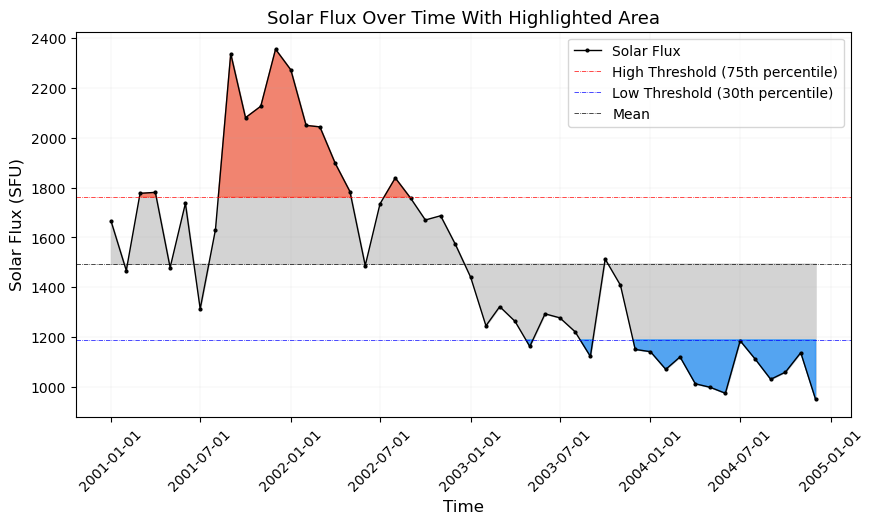

In [15]:
# Assigning Threshold
solar_flux = ds_indices.solar_flux
threshold_high = solar_flux.quantile(0.75)
threshold_low = solar_flux.quantile(0.30)
mean = solar_flux.mean()
print(threshold_high.values, threshold_low.values, mean.values)

plt.figure(figsize=(10, 5))
plt.plot(ds_indices['mpl_time'], ds_indices['solar_flux'], linestyle='-', linewidth=1, marker='o', markersize=2, color='k', label='Solar Flux')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Solar Flux (SFU)', fontsize=12)
plt.title('Solar Flux Over Time With Highlighted Area', fontsize=13)

plt.grid(linewidth=0.09)

# Convert 'mpl_time' for the x-axis.
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.axhline(threshold_high, color='red', linewidth=0.5, linestyle='-.', label='High Threshold (75th percentile)')
plt.axhline(threshold_low,  color='blue', linewidth=0.5, linestyle='-.', label='Low Threshold (30th percentile)')
plt.axhline(mean,  color='black', linewidth=0.5, linestyle='-.', label='Mean')

# 'mpl_time' for the x-axis data in fill_between.
plt.fill_between(ds_indices['mpl_time'], mean, ds_indices['solar_flux'], interpolate=True, color='lightgrey')
plt.fill_between(ds_indices['mpl_time'], threshold_high, ds_indices['solar_flux'], where=(ds_indices['solar_flux'] >= threshold_high), interpolate=True, color='tomato', alpha=0.7)
plt.fill_between(ds_indices['mpl_time'], threshold_low, ds_indices['solar_flux'], where=(ds_indices['solar_flux'] <= threshold_low), interpolate=True, color='dodgerblue', alpha=0.7)

plt.legend()
plt.show()

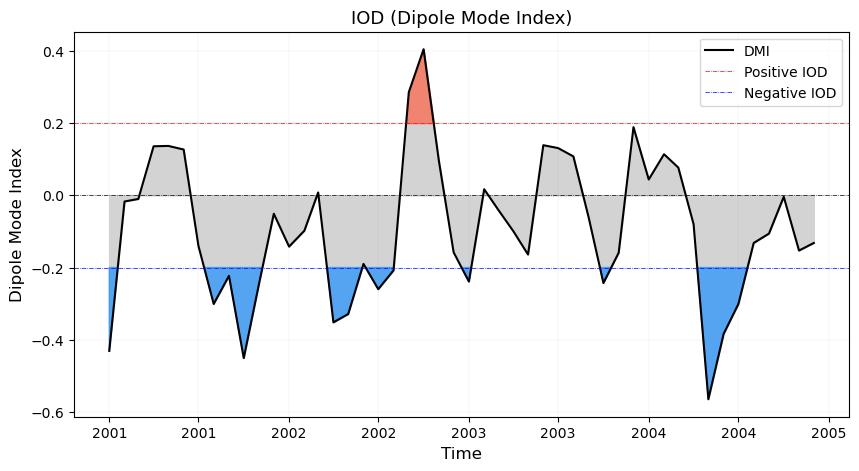

In [16]:
# Assigning Threshold
dmi = ds_indices.dmi
threshold_high = 0.2
threshold_low = -0.2
mean = dmi.mean()

plt.figure(figsize=(10, 5))
plt.plot(ds_indices['time'], ds_indices['dmi'], color='k', label='DMI')

plt.xlabel('Time', fontsize=12)
plt.ylabel('Dipole Mode Index', fontsize=12)
plt.title('IOD (Dipole Mode Index)', fontsize=13)

plt.grid(linewidth=0.09)

# Convert 'mpl_time' for the x-axis.
plt.xticks()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.axhline(threshold_high, color='red', linewidth=0.5, linestyle='-.', label='Positive IOD')
plt.axhline(threshold_low,  color='blue', linewidth=0.5, linestyle='-.', label='Negative IOD')
plt.axhline(0,  color='black', linewidth=0.5, linestyle='-.')

# 'mpl_time' for the x-axis data in fill_between.
plt.fill_between(ds_indices['mpl_time'], 0, ds_indices['dmi'], interpolate=True, color='lightgrey')
plt.fill_between(ds_indices['mpl_time'], threshold_high, ds_indices['dmi'], where=(ds_indices['dmi'] >= threshold_high), interpolate=True, color='tomato', alpha=0.7)
plt.fill_between(ds_indices['mpl_time'], threshold_low, ds_indices['dmi'], where=(ds_indices['dmi'] <= threshold_low), interpolate=True, color='dodgerblue', alpha=0.7)

plt.legend()
plt.show()

Text(0.5, 1.0, 'ENSO (Nino 3.4)')

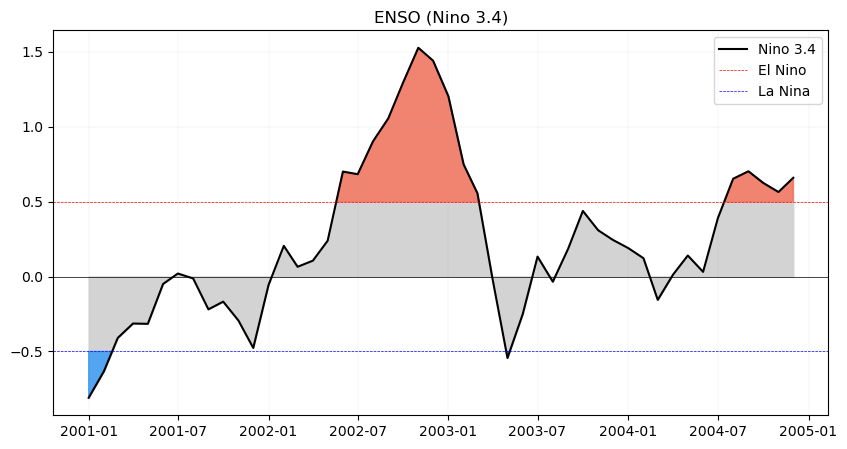

In [17]:
# ENSO
ENSO_threshold_high = 0.5
ENSO_threshold_low = -0.5

# elnino = ds_indices['sst'].where(ds_indices['sst']>=ENSO_threshold_high) 
# lanina = ds_indices['sst'].where(ds_indices['sst']<=ENSO_threshold_low)
# neutral = ds_indices['sst'].where((ds_indices['sst']>-1) & (ds_indices['sst']<1))

plt.figure(figsize=(10, 5))
plt.plot(ds_indices['time'],ds_indices['sst'],'k', label='Nino 3.4')
plt.fill_between(ds_indices['time'].values,ds_indices['sst'],color='lightgray')
# plt.fill_between(ds_indices['time'].values,elnino,y2=1.0, interpolate=True, color='tomato', alpha=0.7)
# plt.fill_between(ds_indices['time'].values,lanina,y2=-1.0, interpolate=True, color='dodgerblue', alpha=0.7)
plt.fill_between(ds_indices['mpl_time'], ENSO_threshold_high, ds_indices['sst'], where=(ds_indices['sst'] >= ENSO_threshold_high), interpolate=True, color='tomato', alpha=0.7) #Mpl time helps edging
plt.fill_between(ds_indices['mpl_time'], ENSO_threshold_low, ds_indices['sst'], where=(ds_indices['sst'] <= ENSO_threshold_low),  interpolate=True, color='dodgerblue', alpha=0.7) 


plt.axhline(0,color='black',linewidth=0.5)
plt.axhline(ENSO_threshold_high,color='red',linewidth=0.5,linestyle='--', label='El Nino')
plt.axhline(ENSO_threshold_low,color='blue',linewidth=0.5,linestyle='--', label='La Nina')
plt.grid(linewidth=0.09)
plt.legend(loc=1)
plt.title("ENSO (Nino 3.4)")

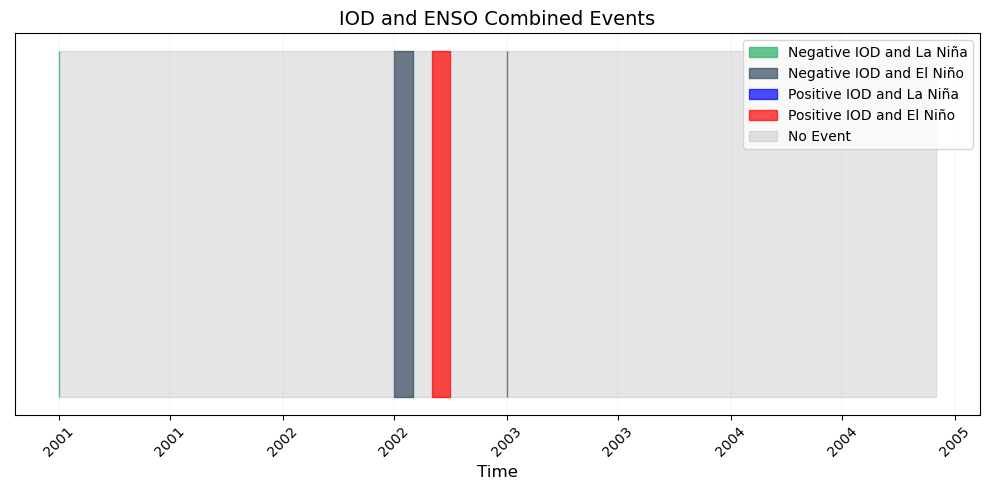

In [18]:
# Define the conditions for IOD and ENSO
positive_iod = ds_indices['dmi'] > threshold_high
negative_iod = ds_indices['dmi'] < threshold_low
el_nino = ds_indices['sst'] >= ENSO_threshold_high
la_nina = ds_indices['sst'] <= ENSO_threshold_low

# Define the four metrics
positive_iod_el_nino = positive_iod & el_nino
positive_iod_la_nina = positive_iod & la_nina
negative_iod_el_nino = negative_iod & el_nino
negative_iod_la_nina = negative_iod & la_nina

plt.figure(figsize=(10, 5))  
times = ds_indices['time'].values

# Plot all metrics on the same axes
def plot_metric(ax, times, metric, label, color):
    metric_int = metric.astype(int)
    ax.fill_between(times, 0, metric_int, where=metric, color=color, alpha=0.7, label=label)

# Create a single axes object
ax = plt.gca()

# Calculating and ploting a mask where no conditions are met
no_event = ~(positive_iod_el_nino | positive_iod_la_nina | negative_iod_el_nino | negative_iod_la_nina)
ax.fill_between(times, 0, 1, color='gray', alpha=0.2, label='No Event')

# Each of the conditions
plot_metric(ax, times, positive_iod_el_nino, 'Positive IOD and El Niño', 'red')
plot_metric(ax, times, positive_iod_la_nina, 'Positive IOD and La Niña', 'blue')
plot_metric(ax, times, negative_iod_el_nino, 'Negative IOD and El Niño', '#34495e')
plot_metric(ax, times, negative_iod_la_nina, 'Negative IOD and La Niña', '#27ae60')

# Format the x-axis with dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax.get_xticklabels(), fontsize=10, rotation=45)

# Set labels and title
ax.set_xlabel('Time', fontsize=12)
ax.set_title('IOD and ENSO Combined Events', fontsize=14)

# Remove the y-axis ticks
ax.set_yticks([])

# Legends
handles, labels = ax.get_legend_handles_labels()
order = [4, 3, 2, 1, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

ax.grid(True, linewidth=0.09)

plt.tight_layout()
plt.show()


In [19]:
# evaporation --> daily
ds_climo = ds.ET_daily.groupby('time.month').mean()
ds_anom = ds.ET_daily.groupby('time.month') - ds_climo
ds_anom

<xarray.DataArray 'ET_daily' (time: 1461, lat: 680, lon: 820)>
dask.array<getitem, shape=(1461, 680, 820), dtype=float32, chunksize=(31, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon      (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0
  * time     (time) datetime64[ns] 2001-01-01T12:00:00 ... 2004-12-31T12:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

In [20]:
# Resample the daily data to monthly averages
ds_anom_monthly = ds_anom.resample(time='M').mean()
ds_anom_monthly['time']= ds_anom_monthly['time'].values.astype('datetime64[M]')
ds_anom_monthly

<xarray.DataArray 'ET_daily' (time: 48, lat: 680, lon: 820)>
dask.array<stack, shape=(48, 680, 820), dtype=float32, chunksize=(1, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
  * lat      (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon      (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0

In [21]:
positive_iod_el_nino = ds_anom_monthly.sel(time=positive_iod_el_nino.time).where(positive_iod_el_nino, drop=True).mean(dim='time')
positive_iod_la_nina = ds_anom_monthly.sel(time=positive_iod_la_nina.time).where(positive_iod_la_nina, drop=True).mean(dim='time')
negative_iod_el_nino = ds_anom_monthly.sel(time=negative_iod_el_nino.time).where(negative_iod_el_nino, drop=True).mean(dim='time')
negative_iod_la_nina = ds_anom_monthly.sel(time=negative_iod_la_nina.time).where(negative_iod_la_nina, drop=True).mean(dim='time')
no_event = ds_anom_monthly.sel(time=no_event.time).where(no_event, drop=True).mean(dim='time')

In [22]:
positive_iod_el_nino

<xarray.DataArray 'ET_daily' (lat: 680, lon: 820)>
dask.array<mean_agg-aggregate, shape=(680, 820), dtype=float32, chunksize=(40, 40), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon      (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0

In [23]:
print('negative_iod_la_nina Max:', np.nanmax(negative_iod_la_nina))
print('negative_iod_la_nina Min:', np.nanmin(negative_iod_la_nina))
print('positive_iod_el_nino Max:', np.nanmax(positive_iod_el_nino))
print('positive_iod_el_nino Min:', np.nanmin(positive_iod_el_nino))
print('positive_iod_la_nina Max:', np.nanmax(positive_iod_la_nina))
print('positive_iod_la_nina Min:', np.nanmin(positive_iod_la_nina))
print('negative_iod_el_nino Max:', np.nanmax(negative_iod_el_nino))
print('negative_iod_el_nino Min:', np.nanmin(negative_iod_el_nino))
print('no_event Max:', np.nanmax(no_event))
print('no_event Min:', np.nanmin(no_event))

negative_iod_la_nina Max: 0.17428929
negative_iod_la_nina Min: -0.062975936
positive_iod_el_nino Max: 0.09367619
positive_iod_el_nino Min: -0.08736773
positive_iod_la_nina Max: nan
positive_iod_la_nina Min: nan
negative_iod_el_nino Max: 0.050958723
negative_iod_el_nino Min: -0.055231515
no_event Max: 0.007804906
no_event Min: -0.008661308


In [24]:
print('negative_iod_la_nina Standard Deviation:', np.std(negative_iod_la_nina).values)
print('positive_iod_el_nino Standard Deviation:', np.std(positive_iod_el_nino).values)
print('positive_iod_la_nina Standard Deviation:', np.std(positive_iod_la_nina).values)
print('negative_iod_el_nino Standard Deviation:', np.std(negative_iod_el_nino).values)
print('no_event Standard Deviation:', np.std(no_event).values)

negative_iod_la_nina Standard Deviation: 0.013877462
positive_iod_el_nino Standard Deviation: 0.0071630613
positive_iod_la_nina Standard Deviation: nan
negative_iod_el_nino Standard Deviation: 0.0049481806
no_event Standard Deviation: 0.00058027526


Text(0.5, 0.98, 'Composite Mean Evaporation Anomaly of Australia')

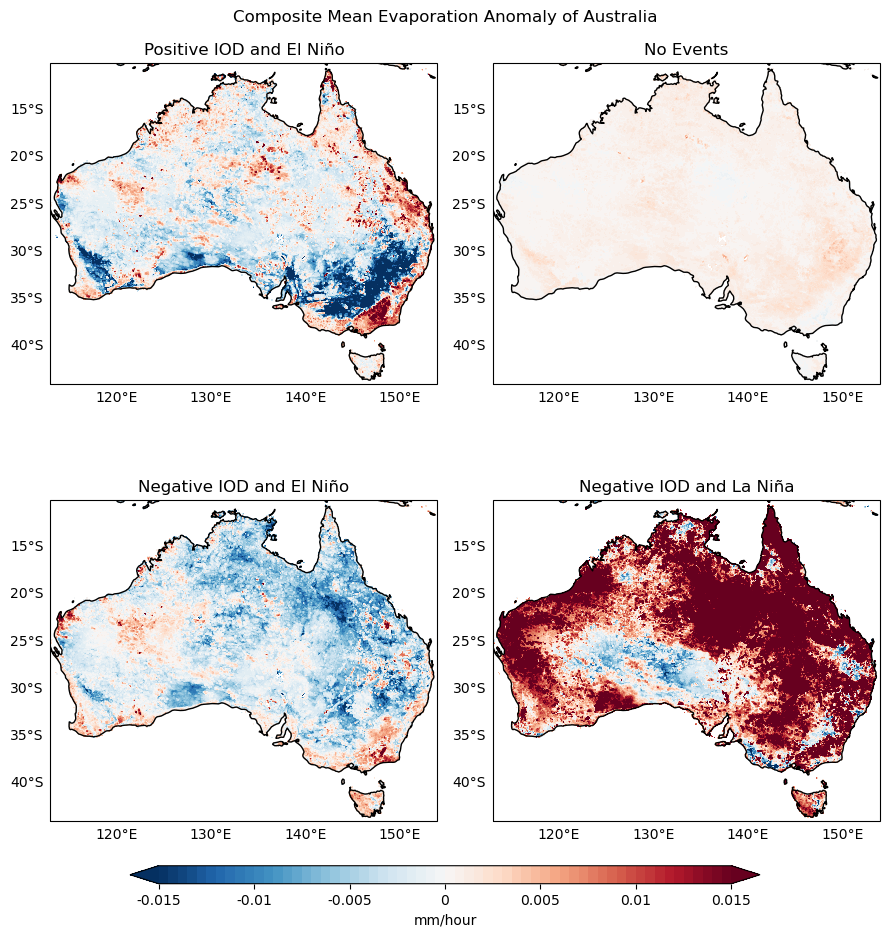

In [25]:
labels = ['Positive IOD and El Niño',
'No Events',
'Negative IOD and El Niño',
'Negative IOD and La Niña',]

clevs = np.linspace(-0.015, 0.015, 61)
comp_evap=[positive_iod_el_nino,no_event,negative_iod_el_nino,negative_iod_la_nina]

fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(9,9))

axs = axs.flatten()

for i, evap in enumerate(comp_evap):
        data = comp_evap[i]
        data, lons = add_cyclic_point(data, coord=comp_evap[i]['lon'])

        # Contour plot
        cs = axs[i].contourf(lons, comp_evap[i]['lat'], data, clevs,
                             transform=ccrs.PlateCarree(),
                             cmap='RdBu_r', extend='both')
        
        axs[i].set_title(labels[i])
        axs[i].coastlines()
        axs[i].set_extent([113, 154, -44, -10], crs=ccrs.PlateCarree())
        
        # Adding gridlines
        gl = axs[i].gridlines(draw_labels=True, linewidth=0)
        gl.top_labels = False
        gl.right_labels = False
        
# Adjust the layout parameters
fig.tight_layout()  

# Colorbar and title settings
cbar_ax = fig.add_axes([0.15, 0.009, 0.7, 0.02]) # x-position, y-position, width, height
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', ticks=[-0.015, -0.010, -0.005, 0, 0.005, 0.010, 0.015], label='mm/hour')
cbar.set_ticklabels([-0.015, -0.010, -0.005, 0, 0.005, 0.010, 0.015])  # Explicitly set the tick labels for clarity
plt.suptitle('Composite Mean Evaporation Anomaly of Australia')

# Correlation between Nino 3.4 and Evaporation

In [26]:
ds_anom_monthly

<xarray.DataArray 'ET_daily' (time: 48, lat: 680, lon: 820)>
dask.array<stack, shape=(48, 680, 820), dtype=float32, chunksize=(1, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
  * lat      (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon      (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0

In [27]:
ds_indices

<xarray.Dataset>
Dimensions:     (time: 48, mpl_time: 48)
Coordinates:
  * time        (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
    month       (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * mpl_time    (mpl_time) float64 1.132e+04 1.135e+04 ... 1.272e+04 1.275e+04
Data variables:
    sst         (time) float32 -0.8092 -0.6318 -0.4097 ... 0.6253 0.5642 0.6593
    solar_flux  (time) float32 1.666e+03 1.467e+03 1.777e+03 ... 1.137e+03 950.0
    dmi         (time) float32 -0.431 -0.017 -0.01 ... -0.004 -0.153 -0.132

In [28]:
# pick a point from evaporation anomaly 
et = ds_anom_monthly.sel(lat=-25, lon=140, method='nearest')
et

<xarray.DataArray 'ET_daily' (time: 48)>
dask.array<getitem, shape=(48,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
    lat      float64 -24.98
    lon      float64 140.0

Text(0, 0.5, 'Niño3.4 Index')

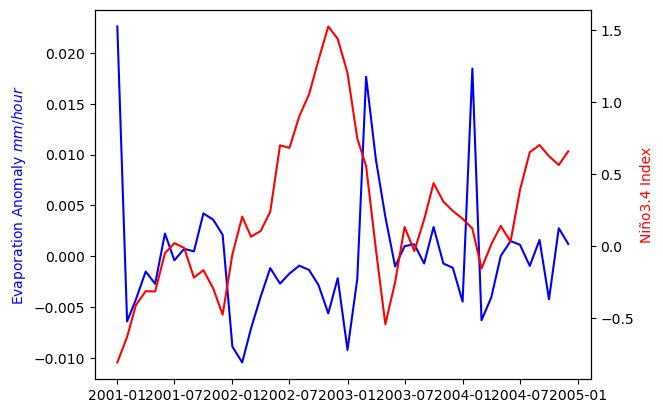

In [29]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(et['time'], et, 'b')
ax2.plot(ds_indices['time'], ds_indices['sst'], 'r')
ax1.set_ylabel('Evaporation Anomaly $mm/hour$', color='b')
ax2.set_ylabel('Niño3.4 Index', color='r') 

In [30]:
et

<xarray.DataArray 'ET_daily' (time: 48)>
dask.array<getitem, shape=(48,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
    lat      float64 -24.98
    lon      float64 140.0

In [31]:
ds_indices['sst']

<xarray.DataArray 'sst' (time: 48)>
array([-0.809223, -0.631765, -0.409744, -0.313438, -0.31562 , -0.049339,
        0.020302, -0.01269 , -0.218927, -0.167503, -0.294001, -0.476536,
       -0.056461,  0.205053,  0.065296,  0.106123,  0.239197,  0.700861,
        0.683123,  0.902231,  1.055616,  1.293997,  1.5273  ,  1.441082,
        1.203978,  0.748455,  0.556095, -0.02162 , -0.543522, -0.250359,
        0.133263, -0.034409,  0.184654,  0.437937,  0.309258,  0.244583,
        0.190218,  0.122515, -0.155806,  0.012741,  0.14036 ,  0.031359,
        0.389746,  0.652849,  0.702755,  0.625296,  0.56424 ,  0.659281],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [32]:
R = np.corrcoef(ds_indices['sst'],et)
R

array([[ 1.        , -0.24106778],
       [-0.24106778,  1.        ]])

In [33]:
corr = R[0,1]
corr

-0.24106778170606896

In [34]:
ds_anom_monthly

<xarray.DataArray 'ET_daily' (time: 48, lat: 680, lon: 820)>
dask.array<stack, shape=(48, 680, 820), dtype=float32, chunksize=(1, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
  * lat      (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon      (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0

In [35]:
month_values = ds_anom_monthly['time'].dt.month
ds_anom_monthly = ds_anom_monthly.assign_coords(month=month_values)
ds_anom_monthly

<xarray.DataArray 'ET_daily' (time: 48, lat: 680, lon: 820)>
dask.array<stack, shape=(48, 680, 820), dtype=float32, chunksize=(1, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
  * lat      (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon      (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [36]:
r_map = xr.corr(ds_indices['sst'],ds_anom_monthly,dim='time')
r_map

<xarray.DataArray (lat: 680, lon: 820)>
dask.array<truediv, shape=(680, 820), dtype=float64, chunksize=(40, 40), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon      (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0

In [37]:
ds_anom_monthly

<xarray.DataArray 'ET_daily' (time: 48, lat: 680, lon: 820)>
dask.array<stack, shape=(48, 680, 820), dtype=float32, chunksize=(1, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2004-12-01
  * lat      (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon      (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [38]:
r_map

<xarray.DataArray (lat: 680, lon: 820)>
dask.array<truediv, shape=(680, 820), dtype=float64, chunksize=(40, 40), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -10.03 -10.07 -10.12 -10.18 ... -43.88 -43.92 -43.98
  * lon      (lon) float64 113.0 113.1 113.1 113.2 ... 153.8 153.9 153.9 154.0

In [39]:
r_map = r_map.values

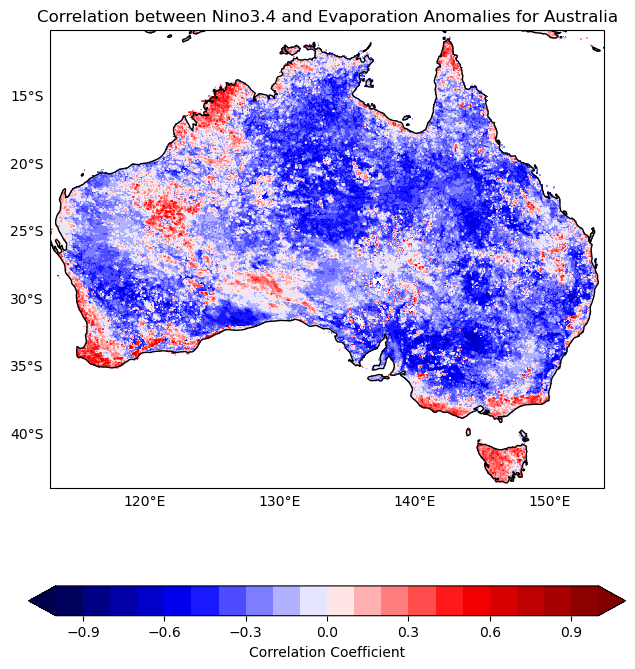

In [40]:
lon_values = ds_anom_monthly['lon']
lat_values = ds_anom_monthly['lat']

data, lon_cyclic = add_cyclic_point(r_map, coord=lon_values)

clevs = np.arange(-1, 1.1, 0.1)
fig = plt.figure(figsize=(11, 8.5))

ax = plt.axes(projection=ccrs.PlateCarree())
cs = ax.contourf(lon_cyclic, lat_values, data, clevs, transform=ccrs.PlateCarree(), cmap='seismic', extend='both')

ax.coastlines()

# Adding gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0)
gl.top_labels = False
gl.right_labels = False

cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.7, label='Correlation Coefficient')
plt.title('Correlation between Nino3.4 and Evaporation Anomalies for Australia')
plt.show()

In [45]:
def clean_data_v2(data, default_value=0):
    """
    first replacing inf values with NaN.
    Then, replace NaNs with the mean of the data, ensuring that the mean is finite.
    If the mean is not finite, replace NaNs with a default value.
    """
    # Replace inf with NaN
    data[np.isinf(data)] = np.nan

    # Calculate the mean, ensuring it's finite
    mean_value = np.nanmean(data)
    if not np.isfinite(mean_value):
        mean_value = default_value

    # Replace NaNs with the mean or default value
    return np.nan_to_num(data, nan=mean_value)

# Apply the revised cleaning process
ds_indices_sst_clean_v2 = clean_data_v2(ds_indices.sst)
ds_anom_monthly_clean_v2 = np.apply_along_axis(clean_data_v2, 0, ds_anom_monthly)

# Recalculate Pearson correlation
for i in range(nx):
    for j in range(ny):
        r, p = pearsonr(ds_indices_sst_clean_v2, ds_anom_monthly_clean_v2[:, j, i])
        r_array[j, i] = r
        p_array[j, i] = p

r_array, p_array  # Display the correlation and p-value arrays


(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]))

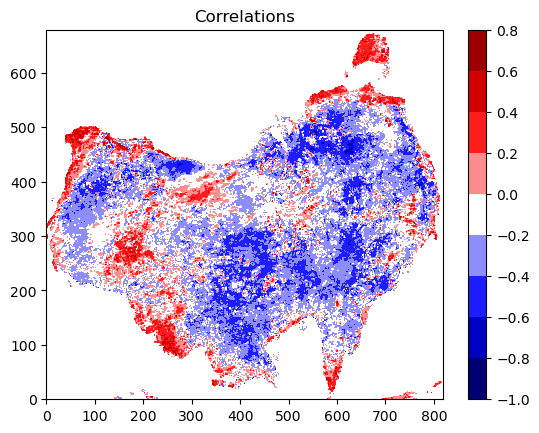

In [46]:
plt.contourf(r_array,cmap='seismic')
plt.title("Correlations")
plt.colorbar() ;

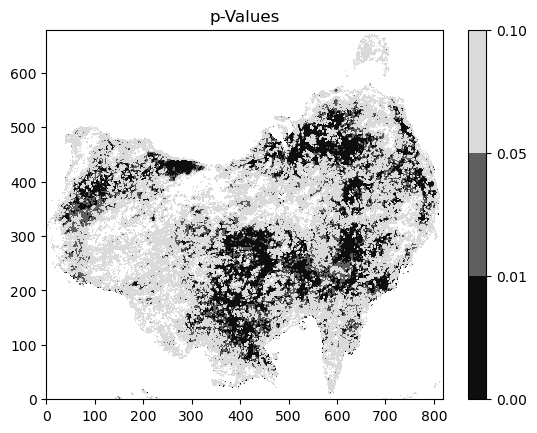

In [47]:
plt.contourf(p_array,[0,0.01,0.05,0.1],cmap='Greys_r')
plt.title("p-Values")
plt.colorbar() ;

In [ ]:
# 5 %
mask_sig=np.where(p_array<0.05,r_array,np.nan)

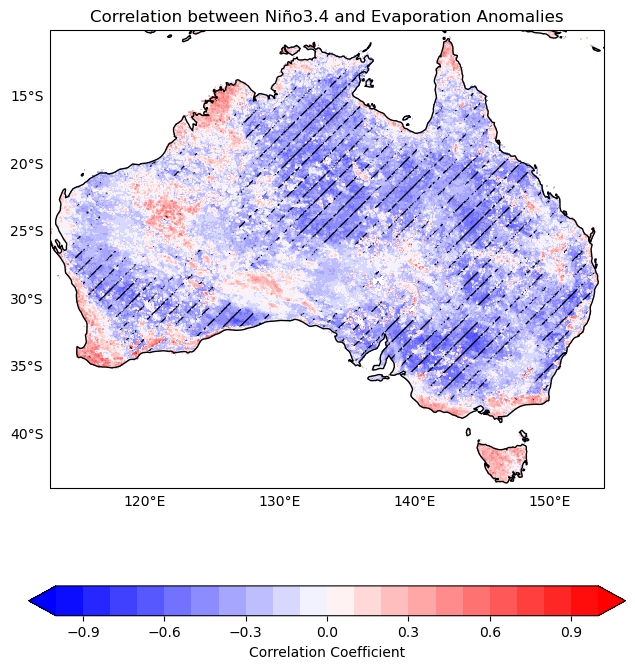

In [53]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Add cyclic point
data=r_array
data,lon=add_cyclic_point(data,coord=ds_anom_monthly['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=ds_anom_monthly['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anom_monthly['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

ax.contourf(lon,ds_anom_monthly['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['//','\\\\'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()


# Adding gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0)
gl.top_labels = False
gl.right_labels = False


# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between Niño3.4 and Evaporation Anomalies') ;

In [56]:
from scipy.stats import linregress

In [ ]:
nx = len(ds_anom_monthly['lon'])
ny = len(ds_anom_monthly['lat'])

p_array = np.zeros((ny, nx)) # p_value
r_array = np.zeros((ny, nx)) # correlation
m_array = np.zeros((ny, nx)) # slope

x = ds_indices['sst']

for j in range(ny):
    print(f"{j},", end=" ")
    for i in range(nx):
        y = ds_anom_monthly[:, j, i]
        m,b,r,p,e = linregress(x,y)
        
        m_array[j,i] = m
        r_array[j,i] = r
        p_array[j,i] = p

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 

In [ ]:
# Create a DataArray with all the details
da_m = xr.DataArray(m_array,
                    coords={'lat':ds_anom_monthly['lat'],
                            'lon': ds_anom_monthly['lon']},
                    dims=['lat','lon'],
                    name='slope',
                    attrs={'name':'regression coefficient',
                           'units':'mm/hour',
                           'description':'Linear regression of monthly evaporation against Niño3.4 index'})
# Convert the DataArray into a Dataset
ds_m = da_m.to_dataset()
ds_m = ds_m.assign_attrs({'start date':np.datetime_as_string(ds_anom_monthly['time'][0]).split('T')[0],
                          'end date':np.datetime_as_string(ds_anom_monthly['time'][-1]).split('T')[0]})
ds_m

In [ ]:

# Create more DataArrays
da_r = xr.DataArray(r_array,
                    coords={'lat':ds_anom_monthly['lat'],
                            'lon': ds_anom_monthly['lon']},
                    dims=['lat','lon'],
                    name='corr',
                    attrs={'name':'correlation coefficient',
                           'units':'none',
                           'description':'Correlation between monthly evaporation and Niño3.4 index'})
da_p = xr.DataArray(p_array,
                    coords={'lat':ds_anom_monthly['lat'],
                            'lon': ds_anom_monthly['lon']},
                    dims=['lat','lon'],
                    name='p',
                    attrs={'name':'p-value',
                           'units':'none',
                           'description':'Signficance of regression of monthly evaporation against Niño3.4 index'})

# Convert the DataArrays into Datasets
ds_r = da_r.to_dataset()
ds_p = da_p.to_dataset()

In [ ]:
ds_regr = xr.merge([ds_m,ds_p,ds_r])
ds_regr

In [ ]:
ds_regr = ds_m
ds_regr['p'] = da_p
ds_regr['corr'] = da_r
ds_regr

In [ ]:
ds_regr = xr.Dataset(data_vars={'slope':da_m,'p':da_p,'corr':da_r})
ds_regr = ds_regr.assign_attrs({'start date':np.datetime_as_string(ds_anom_monthly['time'][0]).split('T')[0],
                                'end date':np.datetime_as_string(ds_anom_monthly['time'][-1]).split('T')[0]})
ds_regr

In [ ]:
ds_regr.to_netcdf('AUS regression.nc')
ds_check=xr.open_dataset('AUS regression.nc')
ds_check

Text(0.5, 0.98, 'Composite Mean Evaporation Anomaly')

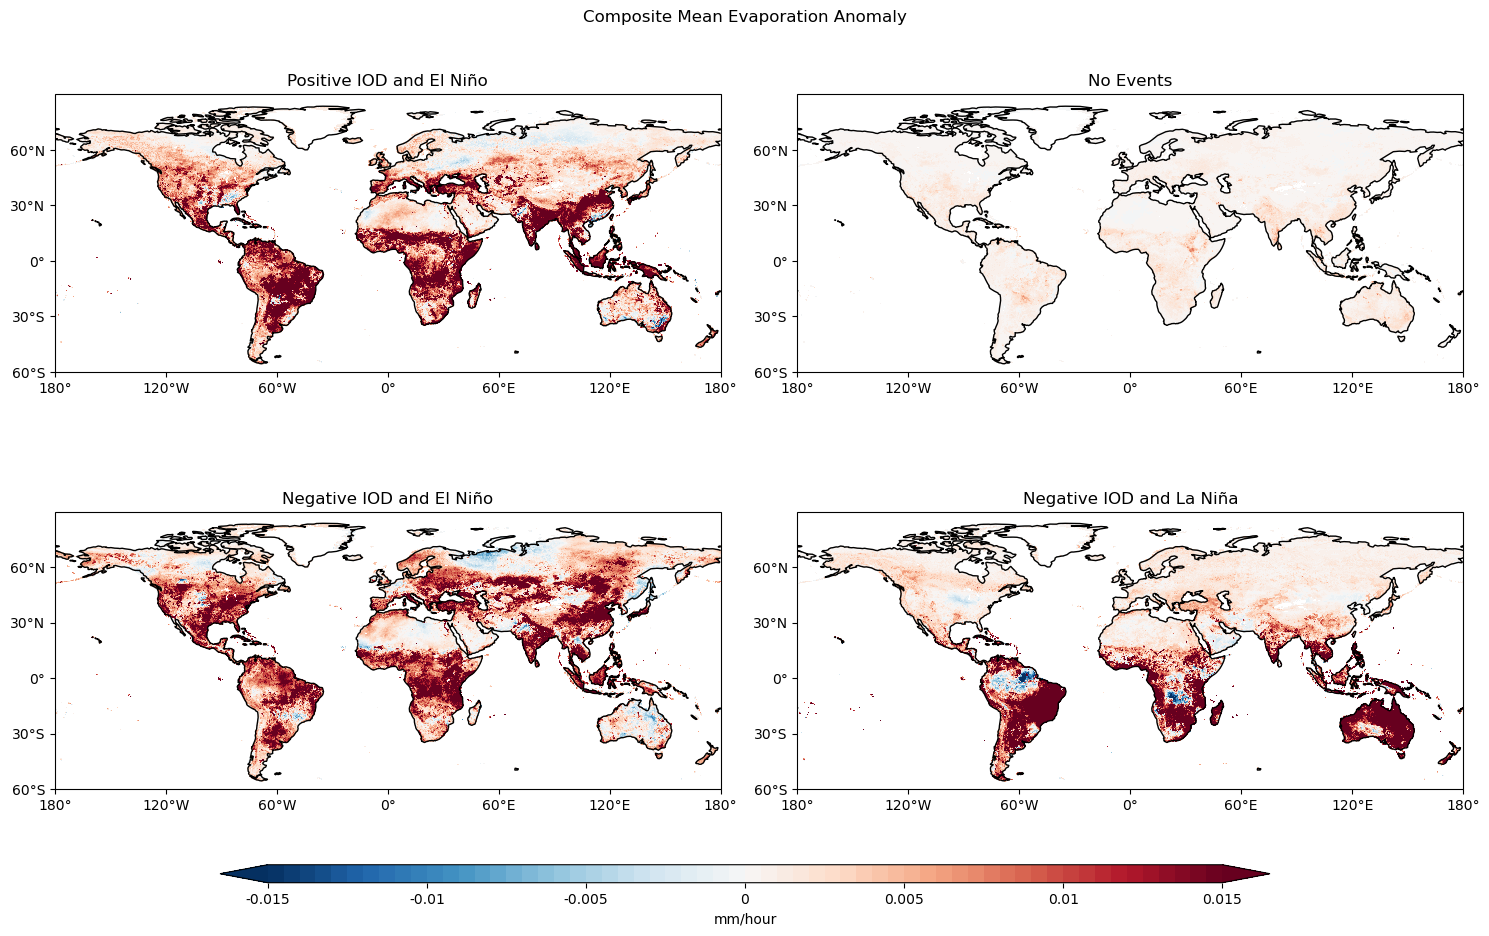

In [42]:
labels = ['Positive IOD and El Niño',
'No Events',
'Negative IOD and El Niño',
'Negative IOD and La Niña',]

clevs = np.linspace(-0.015, 0.015, 61)
comp_evap=[positive_iod_el_nino,no_event,negative_iod_el_nino,negative_iod_la_nina]

fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,9))

axs = axs.flatten()

for i, evap in enumerate(comp_evap):

        data = comp_evap[i]
        data, lons = add_cyclic_point(data, coord=comp_evap[i]['lon'])

        # Contour plot
        cs = axs[i].contourf(lons, comp_evap[i]['lat'], data, clevs,
                             transform=ccrs.PlateCarree(),
                             cmap='RdBu_r', extend='both')

        # Longitude and Latitude labels
       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,61,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        axs[i].set_title(labels[i])
        axs[i].coastlines()
        axs[i].set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

# Adjust the layout parameters
fig.tight_layout()  # Apply tight layout first

# Colorbar and title settings
cbar_ax = fig.add_axes([0.15, 0.01, 0.7, 0.02]) # x-position, y-position, width, height
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', ticks=[-0.015, -0.010, -0.005, 0, 0.005, 0.010, 0.015], label='mm/hour')
cbar.set_ticklabels([-0.015, -0.010, -0.005, 0, 0.005, 0.010, 0.015])  # Explicitly set the tick labels for clarity
plt.suptitle('Composite Mean Evaporation Anomaly')

# Let's work on Australia

Text(0.5, 0.98, 'Composite Mean Evaporation Anomaly')

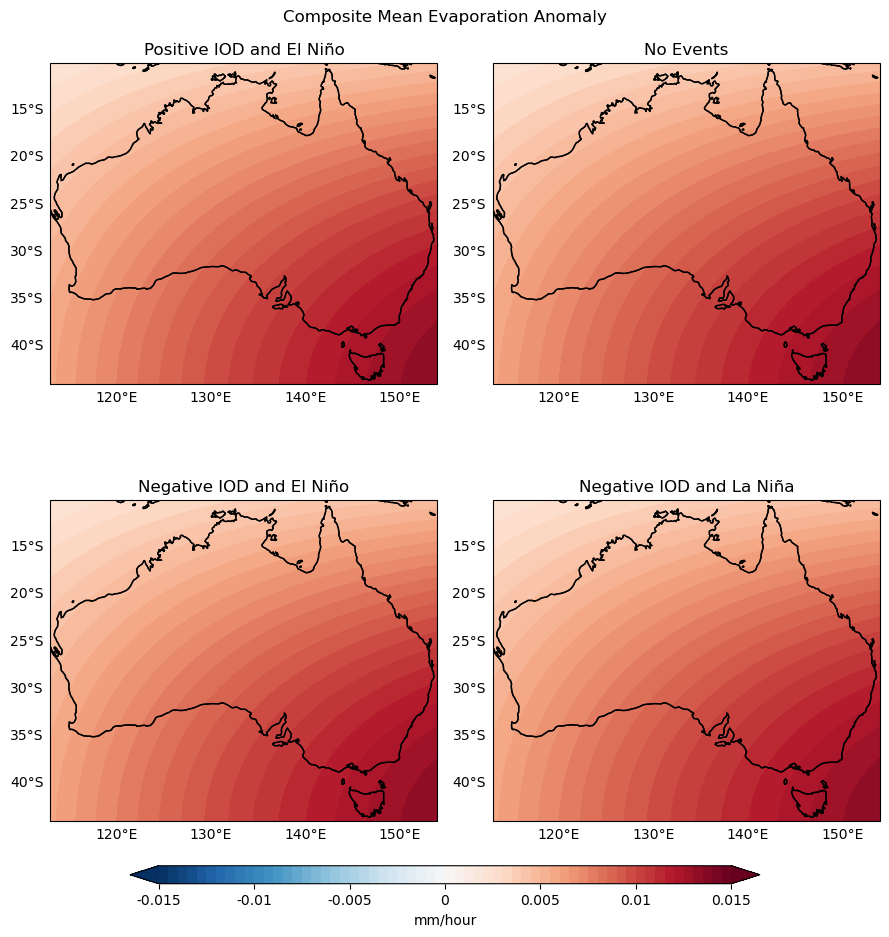

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

# Define labels and the color levels
labels = ['Positive IOD and El Niño', 'No Events', 'Negative IOD and El Niño', 'Negative IOD and La Niña']
clevs = np.linspace(-0.015, 0.015, 61)

# Generate synthetic data for each subplot
def generate_synthetic_data():
    lat = np.linspace(-90, 90, 180)  # 180 points from the South Pole to the North Pole
    lon = np.linspace(-180, 180, 360)  # 360 points from -180 to 180 degrees
    data = np.sin(np.pi * lat[:, None] / 90) * np.cos(np.pi * lon[None, :] / 180) * 0.015
    return data, lat, lon

# Generate a list of synthetic datasets
comp_evap = [generate_synthetic_data() for _ in labels]

fig, axs = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 9))
axs = axs.flatten()

for i, (data, lat, lon) in enumerate(comp_evap):
    data, lons = add_cyclic_point(data, coord=lon)

    # Contour plot
    cs = axs[i].contourf(lons, lat, data, clevs, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
    axs[i].set_title(labels[i])
    axs[i].coastlines()
    axs[i].set_title(labels[i])
    axs[i].coastlines()
    axs[i].set_extent([113, 154, -44, -10], crs=ccrs.PlateCarree())
    
    
    # Adding gridlines
    gl = axs[i].gridlines(draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    # gl.bottom_labels = i//3==3 
    # gl.left_labels = i % 3 == 0 

# Adjust the layout parameters
fig.tight_layout()  # Apply tight layout first

# Colorbar and title settings
cbar_ax = fig.add_axes([0.15, 0.009, 0.7, 0.02]) # x-position, y-position, width, height
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', ticks=[-0.015, -0.010, -0.005, 0, 0.005, 0.010, 0.015], label='mm/hour')
cbar.set_ticklabels([-0.015, -0.010, -0.005, 0, 0.005, 0.010, 0.015])  # Explicitly set the tick labels for clarity
plt.suptitle('Composite Mean Evaporation Anomaly')